In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/papsinglecell/SingleCellPAP/Training/im_Parabasal/025_01.bmp
/kaggle/input/papsinglecell/SingleCellPAP/Training/im_Parabasal/001_01.bmp
/kaggle/input/papsinglecell/SingleCellPAP/Training/im_Parabasal/006_04.bmp
/kaggle/input/papsinglecell/SingleCellPAP/Training/im_Parabasal/052_04.bmp
/kaggle/input/papsinglecell/SingleCellPAP/Training/im_Parabasal/072_07.bmp
/kaggle/input/papsinglecell/SingleCellPAP/Training/im_Parabasal/051_04.bmp
/kaggle/input/papsinglecell/SingleCellPAP/Training/im_Parabasal/028_07.bmp
/kaggle/input/papsinglecell/SingleCellPAP/Training/im_Parabasal/003_13.bmp
/kaggle/input/papsinglecell/SingleCellPAP/Training/im_Parabasal/038_01.bmp
/kaggle/input/papsinglecell/SingleCellPAP/Training/im_Parabasal/047_06.bmp
/kaggle/input/papsinglecell/SingleCellPAP/Training/im_Parabasal/055_01.bmp
/kaggle/input/papsinglecell/SingleCellPAP/Training/im_Parabasal/076_06.bmp
/kaggle/input/papsinglecell/SingleCellPAP/Training/im_Parabasal/092_02.bmp
/kaggle/input/papsinglece

In [2]:
import os
import shutil

# Define the top directory and the paths to the training and test directories
topDir = '/kaggle/'
TnVDir = os.path.join(topDir, 'input/papsinglecell/papsinglecell/SingleCellPAP/Training')
TestDir = os.path.join(topDir, 'input/papsinglecell/SingleCellPAP/Test')
WorkingDir = os.path.join(topDir, 'working/papsinglecell/SingleCellPAP/Training')

# List the folder names in the test directory
folder_names = ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal', 'im_Superficial-Intermediate']

# Create the training directory structure in the working directory
for folder in folder_names:
    os.makedirs(os.path.join(WorkingDir, folder), exist_ok=True)

# Iterate through each folder in the test directory
for folder in folder_names:
    src_folder = os.path.join(TestDir, folder)
    dest_folder = os.path.join(WorkingDir, folder)
    
    # Check if the source folder exists
    if os.path.exists(src_folder):
        # Iterate through each file in the source folder
        for filename in os.listdir(src_folder):
            # Construct the full file path
            src_file = os.path.join(src_folder, filename)
            dest_file = os.path.join(dest_folder, filename)
            
            # Copy the file to the destination folder
            shutil.copy(src_file, dest_file)
        print(f"Copied contents of {src_folder} to {dest_folder}")
    else:
        print(f"Source folder {src_folder} does not exist.")

Copied contents of /kaggle/input/papsinglecell/SingleCellPAP/Test/im_Dyskeratotic to /kaggle/working/papsinglecell/SingleCellPAP/Training/im_Dyskeratotic
Copied contents of /kaggle/input/papsinglecell/SingleCellPAP/Test/im_Koilocytotic to /kaggle/working/papsinglecell/SingleCellPAP/Training/im_Koilocytotic
Copied contents of /kaggle/input/papsinglecell/SingleCellPAP/Test/im_Metaplastic to /kaggle/working/papsinglecell/SingleCellPAP/Training/im_Metaplastic
Copied contents of /kaggle/input/papsinglecell/SingleCellPAP/Test/im_Parabasal to /kaggle/working/papsinglecell/SingleCellPAP/Training/im_Parabasal
Copied contents of /kaggle/input/papsinglecell/SingleCellPAP/Test/im_Superficial-Intermediate to /kaggle/working/papsinglecell/SingleCellPAP/Training/im_Superficial-Intermediate


In [3]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=fd02ce42f44fbbcfeacd1c0cea492d654d784d03d2048c49413a95d5058c2c8a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [4]:
!pip install torchsummary

In [5]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet18

In [6]:
# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform_color = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

transform_greyscale = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [7]:
# Define additional transformations for edge detection
class ScharrEdgeDetection(object):
    def __call__(self, img):
        img = img.numpy().squeeze(0)  # Convert tensor to numpy array and remove channel dimension
        grad_x = cv2.Scharr(img, cv2.CV_64F, 1, 0)
        grad_y = cv2.Scharr(img, cv2.CV_64F, 0, 1)
        scharr_edges = cv2.magnitude(grad_x, grad_y)
        scharr_edges = cv2.normalize(scharr_edges, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        return torch.tensor(scharr_edges, dtype=torch.float32).unsqueeze(0)  # Convert back to tensor and add channel dimension

# Custom dataset class
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform_color=None, transform_greyscale=None, edge_detection=None):
        self.dataset = ImageFolder(root=root)
        self.transform_color = transform_color
        self.transform_greyscale = transform_greyscale
        self.edge_detection = edge_detection

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        path, label = self.dataset.imgs[idx]
        img = self.dataset.loader(path)

        if self.transform_color:
            color_img = self.transform_color(img)
        if self.transform_greyscale:
            grey_img = self.transform_greyscale(img)
        if self.edge_detection:
            edge_img = self.edge_detection(grey_img)

        return edge_img, color_img, label

# Instantiate the dataset
train_dataset = CustomImageDataset(
    root=WorkingDir,
    transform_color=transform_color,
    transform_greyscale=transform_greyscale,
    edge_detection=ScharrEdgeDetection()
)


In [8]:
# # Setting up device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define transformations
# transform_color = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor()
#     transforms.Lambda(lambda x: x.convert('HSV'))
# ])

# transform_greyscale = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])
# ])


In [9]:
# Hyperparameters
batch_size=100
z_dim = 100
num_epochs = 10000
img_shape = (3, 128, 128)
label_shape = (1, 128, 128)
num_classes = 5

In [10]:
def generate_gaussian_noise(shape=(batch_size, z_dim), mean=0, var=0.01):
    sigma = np.sqrt(var)
    gauss = np.random.normal(mean, sigma, shape)
    return gauss

def generate_salt_and_pepper_noise(shape=(batch_size, z_dim), salt_prob=0.05, pepper_prob=0.05):
    noise = np.zeros(shape)
    num_salt = np.ceil(salt_prob * shape[0] * shape[1])
    num_pepper = np.ceil(pepper_prob * shape[0] * shape[1])

    # Add Salt noise
    salt_coords = [np.random.randint(0, i, int(num_salt)) for i in shape]
    noise[salt_coords[0], salt_coords[1]] = 1

    # Add Pepper noise
    pepper_coords = [np.random.randint(0, i, int(num_pepper)) for i in shape]
    noise[pepper_coords[0], pepper_coords[1]] = -1

    return noise

def generate_shot_noise(shape=(batch_size, z_dim), scale=30):
    noise = np.random.poisson(scale, shape) / float(scale)
    return noise

def generate_anisotropic_noise(shape=(batch_size, z_dim), alpha=0.5):
    noise = alpha * (np.random.rand(*shape) - 0.5)
    return noise

def generate_rayleigh_noise(shape=(batch_size, z_dim), scale=0.1):
    rayleigh = np.random.rayleigh(scale, shape)
    return rayleigh

def generate_gamma_noise(shape=(batch_size, z_dim), shape_param=2.0, scale=1.0):
    gamma = np.random.gamma(shape_param, scale, shape)
    return gamma

def generate_exponential_noise(shape=(batch_size, z_dim), scale=1.0):
    exponential = np.random.exponential(scale, shape)
    return exponential

def generate_uniform_noise(shape=(batch_size, z_dim), low=-0.1, high=0.1):
    uniform = np.random.uniform(low, high, shape)
    return uniform

def generate_speckle_noise(shape=(batch_size, z_dim)):
    speckle = np.random.randn(*shape)
    return speckle

def generate_quantization_noise(shape=(batch_size, z_dim), levels=256):
    step = 1.0 / levels
    noise = step * np.random.randint(0, levels, shape) - 0.5
    return noise

def generate_thermal_noise(shape=(batch_size, z_dim), mean=0, std=1):
    thermal_noise = np.random.normal(mean, std, shape)
    return thermal_noise

def generate_brownian_noise(shape=(batch_size, z_dim)):
    dt = 1 / shape[1]
    brownian_noise = np.cumsum(np.random.randn(*shape) * np.sqrt(dt), axis=1)
    return brownian_noise

def generate_pink_noise(shape=(batch_size, z_dim)):
    n = shape[1]
    uneven = n % 2
    X = np.random.randn(n // 2 + 1 + uneven) + 1j * np.random.randn(n // 2 + 1 + uneven)
    S = np.sqrt(np.arange(len(X)) + 1.)
    y = (np.fft.irfft(X / S)).real
    if uneven:
        y = y[:-1]
    pink_noise = y / np.std(y)
    return pink_noise.reshape(shape)

def generate_white_noise(shape=(batch_size, z_dim)):
    white_noise = np.random.normal(0, 1, shape)
    return white_noise

def generate_poisson_gaussian_noise(shape=(batch_size, z_dim), lam=5, mean=0, var=0.01):
    poisson_noise = np.random.poisson(lam, shape)
    gaussian_noise = np.random.normal(mean, np.sqrt(var), shape)
    poisson_gaussian_noise = poisson_noise + gaussian_noise
    return poisson_gaussian_noise

def generate_structured_noise(shape=(batch_size, z_dim), frequency=5):
    t = np.linspace(0, 1, shape[1])
    structured_noise = np.sin(2 * np.pi * frequency * t)
    return structured_noise.reshape(shape)

In [11]:
# Load training dataset
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [12]:
# Example to show how to access images and labels
for edge_imgs, color_imgs, labels in dataloader:
    edge_imgs, color_imgs, labels = edge_imgs.to(device), color_imgs.to(device), labels.to(device)
    print(edge_imgs.shape, color_imgs.shape, labels.shape)
    break

torch.Size([100, 1, 128, 128]) torch.Size([100, 3, 128, 128]) torch.Size([100])


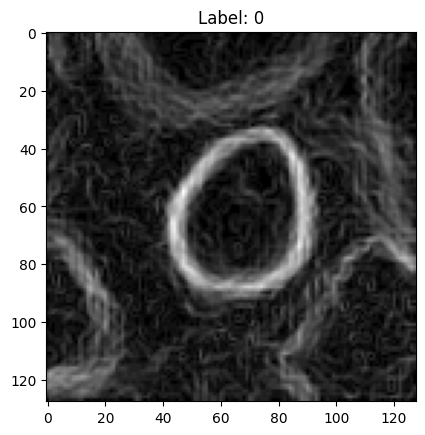

In [13]:
# prompt: plot an image from the images in the training set. after you scale the image to be between 0 and 1, multiply each pixel by 255, and ensure the resultant values are integers. then plot

# Get the first image and label from the training set
image, color, label = train_dataset[0]

# Scale the image to be between 0 and 1
image = image / 2 + 0.5

# Multiply each pixel by 255
image = image * 255

# Ensure the resultant values are integers
image = image.int()

# Plot the image
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.show()

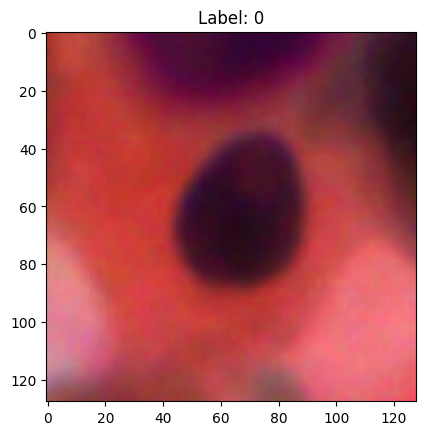

In [14]:
import matplotlib.pyplot as plt

# Assuming 'color' is the tensor you want to plot
image = (color - color.min()) / (color.max() - color.min())  # Unnormalize the image
image = image * 255  # Scale to [0, 255]
image = image.int()  # Ensure the values are integers

# Convert from (C, H, W) to (H, W, C)
image = image.permute(1, 2, 0).cpu().numpy()

# Plot the image
plt.imshow(image.squeeze())
plt.title(f"Label: {label}")
plt.show()

In [15]:
def conv_block(in_channels, out_channels):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return block

def decoder_block(in_channels, out_channels):
    class DecoderBlock(nn.Module):
        def __init__(self, in_channels, out_channels):
            super(DecoderBlock, self).__init__()
            self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
            # self.conv1 = nn.Conv2d(skip_channels + out_channels, out_channels, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.relu1 = nn.ReLU(inplace=True)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.relu2 = nn.ReLU(inplace=True)

            # Adjusting conv_skip_match to match skip_channels
            self.conv_skip_match = nn.Conv2d(624, 552, kernel_size=1, padding=0)

            # Dynamic adjustment based on skip_channels shape
            # self.conv_skip_match = nn.Conv2d(out_channels, skip_channels, kernel_size=1, padding=0)

        def forward(self, x, skip):
            # print("Shape of x before transpose:", x.shape)
            x = self.conv_transpose(x)
            # print("Shape of x after transpose:", x.shape)
            # print("Shape of skip:", skip.shape)
            cat = torch.cat([x, skip], dim=1)
            # print("Shape after concatenation:", cat.shape)
            self.conv_skip_match = nn.Conv2d(cat.shape[1], x.shape[1], kernel_size=1, padding=0).to(device)
            x = self.conv_skip_match(cat).to(device)
            # print("Shape after conv_skip_match:", x.shape)
            # x = self.conv1(x)
            # print("Shape after conv1:", x.shape)
            x = self.bn1(x)
            # print("Shape after BatchNormalization: ",x.shape)
            x = self.relu1(x)
            # print("Shape after ReLU:", x.shape)
            x = self.conv2(x)
            # print("Shape after conv2:", x.shape)
            x = self.bn2(x)
            # print("Shape after BatchNormalization: ",x.shape)
            x = self.relu2(x)
            # print("Shape after decoder block", x.shape)
            return x

    return DecoderBlock(in_channels, out_channels)

In [16]:
# Generator
class Generator_UNetEfficientNetB0(nn.Module):
    def __init__(self, num_classes, z_dim, in_channels=1, out_channels=3):
        super(Generator_UNetEfficientNetB0, self).__init__()

        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.z_dim = z_dim
        self.initial_conv = nn.Conv2d(in_channels + num_classes + z_dim, 3, kernel_size=3, padding=1)

        self.encoder = EfficientNet.from_pretrained('efficientnet-b0')

        self.conv_block1 = conv_block(3, 64)
        self.conv_block2 = conv_block(16, 128)
        self.conv_block3 = conv_block(24, 256)
        self.conv_block4 = conv_block(40, 512)

        self.bottleneck = conv_block(320, 1024)

        # Define the convolutional layer to adjust s1
        self.conv_s1_adjust = nn.Sequential(
            conv_block(64, 64),  # Apply a conv_block to maintain consistency
            nn.Conv2d(64, 256, kernel_size=3, stride=2, padding=1),  # Downsample to 64x64
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder_block1 = decoder_block(1024, 512)
        self.decoder_block2 = decoder_block(512, 256)
        self.decoder_block3 = decoder_block(256, 128)
        self.decoder_block4 = decoder_block(128, 64)

        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Apply a conv_block to maintain consistency
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),  # Upsample to 128x128
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1)  # Adjust to the final number of output channels
        )

    def forward(self, z, labels, x):
        labels = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)
        labels = labels.view(labels.size(0), labels.size(1), 1, 1).expand(-1, -1, x.size(2), x.size(3))
        z = z.view(z.size(0), self.z_dim, 1, 1).expand(-1, -1, x.size(2), x.size(3))
        gen_input = torch.cat((x, labels, z), dim=1)

        gen_input = self.initial_conv(gen_input)

        s1 = self.conv_block1(gen_input)
        s1 = self.conv_s1_adjust(s1)


        # Extract features using named endpoints
        features = self.encoder.extract_endpoints(gen_input)
        s2 = features['reduction_2']
        s3 = features['reduction_3']
        s4 = features['reduction_4']

        b1 = self.bottleneck(features['reduction_5'])
        # print("Shape of bottleneck", b1.shape)

        d1 = self.decoder_block1(b1, s4)
        # print("Shape of d1:", d1.shape)
        d2 = self.decoder_block2(d1, s3)
        # print("Shape of d2:", d2.shape)
        d3 = self.decoder_block3(d2, s2)
        # print("Shape of d3:", d3.shape)
        d4 = self.decoder_block4(d3, s1)
        # print("Shape of d4:", d4.shape)

        out = self.final_conv(d4)
        # print("Shape of out:", out.shape)
        return torch.sigmoid(out)

In [17]:
# Discriminator
class Discriminator_ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator_ResNet18, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        # Load pre-trained ResNet18 model
        self.model = resnet18(pretrained=True)

        # Replace the final fully connected layer
        self.model.fc = nn.Linear(self.model.fc.in_features + num_classes, 1)
        self.linear = nn.Linear(517, 1)  # Convert to a single scalar
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, labels):
        labels = self.label_embedding(labels).view(labels.size(0), -1)
        # print("Shape of labels: ", labels.shape)
        # print("Shape of x: ", x.shape)

        # Extract features from ResNet18
        features = self.model.conv1(x)
        features = self.model.bn1(features)
        features = self.model.relu(features)
        features = self.model.maxpool(features)

        features = self.model.layer1(features)
        features = self.model.layer2(features)
        features = self.model.layer3(features)
        features = self.model.layer4(features)

        # Global average pooling
        features = self.model.avgpool(features)
        features = torch.flatten(features, 1)

        # print("Shape of features: ", features.shape)

        cat = torch.cat((features, labels), dim=1)
        # print("Shape of cat: ", cat.shape)
        d_in = self.linear(cat)
        # print("Shape of d_in: ", d_in.shape)
        validity = self.sigmoid(d_in)
        # print("Shape of validity: ", validity.shape)
        return validity


In [18]:
# Initialize the networks
generator = Generator_UNetEfficientNetB0(num_classes=num_classes,z_dim=z_dim).to(device)
discriminator = Discriminator_ResNet18(num_classes=num_classes).to(device)

# Print network architectures
print(generator)
print(discriminator)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 121MB/s] 


Loaded pretrained weights for efficientnet-b0


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s] 

Generator_UNetEfficientNetB0(
  (label_embedding): Embedding(5, 5)
  (initial_conv): Conv2d(106, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          

In [19]:
# Define loss functions
adversarial_loss = nn.BCELoss()

# Optimizers
lr = 0.0001
beta1 = 0.5
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

'''
introduce resize transformation to ensure images maintain consistency
Shape should be (3,128,128)
'''
resize_transform = transforms.Resize((128, 128))

In [20]:
torch.cuda.is_available()

True

In [21]:
# Ensure the directory for saving generated images exists
output_dir = '/kaggle/working/GeneratedImages/Anisotropic-Noise'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Training loop
for epoch in range(num_epochs):
    for i, (edges, color_images, labels) in enumerate(dataloader):
        batch_size = edges.size(0)

        valid = torch.ones((batch_size, 1), requires_grad=False).to(device)
        fake = torch.zeros((batch_size, 1), requires_grad=False).to(device)

        real_images = color_images.to(device)
        labels = labels.to(device)
        edges = edges.to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        z = generate_anisotropic_noise((batch_size, z_dim))
        z = torch.tensor(z).float().to(device)  # Convert z to PyTorch tensor and move to device

        # Check the shape of the input tensors before passing them to the generator
        # print("Shape of z:", z.shape)
        # print("Shape of labels:", labels.shape)
        # print("Shape of edges:", edges.shape)

        gen_images = generator(z, labels, edges)

        # Resize generated images to the desired shape (3, 128, 128)
        gen_images = transforms.functional.resize(gen_images, (128, 128))

        g_loss = adversarial_loss(discriminator(gen_images, labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Resize real images to the desired shape (3, 128, 128)
        real_images = transforms.functional.resize(real_images, (128, 128))

        real_loss = adversarial_loss(discriminator(real_images, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_images.detach(), labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Empty the cache after each iteration to free up GPU memory
        torch.cuda.empty_cache()

    # Print training stats
    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, num_epochs, d_loss.item(), g_loss.item())
    )
    print("Saving model")
    torch.save(generator.state_dict(), '/kaggle/working/generator_anisotropic.pth')
    torch.save(discriminator.state_dict(), '/kaggle/working/discriminator_anisotropic.pth')

    if (epoch+1) % 1 == 0:
        save_image(gen_images.data[:64], f"/kaggle/working/GeneratedImages/Anisotropic-Noise/Epoch_{epoch+1}.png", nrow=8, normalize=True)

[Epoch 1/10000] [D loss: 0.708081] [G loss: 0.706187]
Saving model
[Epoch 2/10000] [D loss: 0.644635] [G loss: 0.771084]
Saving model
[Epoch 3/10000] [D loss: 0.608289] [G loss: 0.828754]
Saving model
[Epoch 4/10000] [D loss: 0.531449] [G loss: 0.868337]
Saving model
[Epoch 5/10000] [D loss: 0.481911] [G loss: 1.035732]
Saving model
[Epoch 6/10000] [D loss: 0.411804] [G loss: 1.249733]
Saving model
[Epoch 7/10000] [D loss: 0.278626] [G loss: 1.535575]
Saving model
[Epoch 8/10000] [D loss: 0.197976] [G loss: 2.025130]
Saving model
[Epoch 9/10000] [D loss: 0.156537] [G loss: 2.421411]
Saving model
[Epoch 10/10000] [D loss: 0.104234] [G loss: 2.561893]
Saving model
[Epoch 11/10000] [D loss: 0.066903] [G loss: 2.801595]
Saving model
[Epoch 12/10000] [D loss: 0.094914] [G loss: 2.916452]
Saving model
[Epoch 13/10000] [D loss: 0.085809] [G loss: 2.637394]
Saving model
[Epoch 14/10000] [D loss: 0.057769] [G loss: 2.944565]
Saving model
[Epoch 15/10000] [D loss: 0.055572] [G loss: 3.158062]
Sa